<a href="https://colab.research.google.com/github/X-pose/Skin-Disease-Classifiaction-Models---Deep-Learning-Assignment/blob/IT21226632---Weerasinghe-W.W.A.B.M/DenseNet121_Skin_Disease_classification_model_IT21226632.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Libraries

The code begins by importing the required libraries: zipfile for handling zip files and os for interacting with the operating system. The drive module from google.colab is also imported to allow access to Google Drive.
Set CUDA Configuration:

The environment variable PYTORCH_CUDA_ALLOC_CONF is configured to expandable_segments:True.
This setting is intended to optimize CUDA memory allocation for PyTorch, helping to prevent memory-related issues when running deep learning models.
Mount Google Drive:

The code mounts Google Drive to the Colab environment by calling drive.mount('/content/drive').
This step enables access to files stored in the user's Google Drive, allowing the code to read the dataset zip file directly.
Specify the Dataset Zip File Path:

A variable, zip_file_path, is defined to specify the path to the dataset zip file in Google Drive. This path directs the code to the specific file that contains the dataset for skin disease classification.
Define Extraction Directory:

Another variable, extract_dir, is created to specify the directory where the contents of the zip file will be extracted. This directory is set to '/content/Extracted_data'.
Create Extraction Directory:

The os.makedirs function is called with exist_ok=True, ensuring that the extraction directory is created if it does not already exist. This prevents errors if the directory is attempted to be created multiple times.
Extract the Zip File:

The code uses a with statement to open the zip file in read mode. Inside this block, the extractall method of the ZipFile object is invoked to extract all the contents of the zip file into the specified extraction directory.
Confirmation Message:

Finally, a print statement confirms that the dataset has been successfully extracted to the designated directory, informing the user of the completion of the extraction process.


In [20]:
import zipfile
import os
from google.colab import drive
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Mount Google Drive
drive.mount('/content/drive')

# Path to dataset zip file in Google Drive
zip_file_path = '/content/drive/My Drive/Skin Disease.v1i.multiclass.zip'

# Directory to extract the files
extract_dir = '/content/Extracted_data'

# Create directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Dataset extracted to {extract_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/Extracted_data


In [21]:
# Install necessary libraries
!pip install torch torchvision numpy pandas matplotlib scikit-learn


In [22]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets, models
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# SkinDiseaseDataset Class
The SkinDiseaseDataset class extends the Dataset class from PyTorch to manage a dataset of skin disease images and their corresponding labels.

**Initialization (__init__ method):**

The class is initialized with a CSV file containing annotations, a root directory for images, and optional transformations for image preprocessing. The CSV file is read into a DataFrame for easy access to image paths and labels.
Length (__len__ method):

Returns the total number of samples in the dataset based on the number of entries in the annotations.
Get Item (__getitem__ method):

Loads an image from the specified path using its index. If an error occurs while loading the image, it prints an error message and returns None. The corresponding label is retrieved as a tensor. If transformations are provided, they are applied to the image before returning it alongside the label.

In [23]:
class SkinDiseaseDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        try:
            image = Image.open(img_name).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            return None, None  # Handle the error as needed

        label = torch.tensor(self.annotations.iloc[idx, 1:].values.astype('float32'))

        if self.transform:
            image = self.transform(image)

        return image, label

# Dataset Preparation and Data Loading
**Image Transformations:**

Training Transformations (train_transform):

Resizes images to
224
×
224
224×224 pixels.
Applies random horizontal flips and rotations to augment the dataset.
Adjusts brightness, contrast, saturation, and hue.
Applies random affine transformations for slight translations and scaling.
Converts images to tensors and normalizes them using ImageNet statistics.

**Validation Transformations (val_transform):**

Resizes images to
224
×
224
224×224 pixels.
Converts images to tensors and normalizes them similarly to training data.

**Dataset Paths:**

Specifies paths to CSV files containing labels and directories for training and testing images.

**Loading Datasets:**

Initializes SkinDiseaseDataset objects for both training and testing datasets, using the defined transformations.

**Splitting the Dataset:**

Utilizes train_test_split to divide the training dataset into training and validation sets, with 20% reserved for validation.

**Creating Data Loaders:**

Defines DataLoader instances for the training, validation, and test datasets with a batch size of 32.
Enables shuffling for the training data to enhance model training.

In [24]:
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Define image transformations with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for DenseNet
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(10),  # Randomly rotate images
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Change brightness, contrast, saturation
    transforms.RandomAffine(0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for validation
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

# Path to CSV and image folder
train_csv_path = '/content/Extracted_data/train/_classes.csv'
test_csv_path = '/content/Extracted_data/test/_classes.csv'
train_img_dir = '/content/Extracted_data/train'
test_img_dir = '/content/Extracted_data/test'

# Load the datasets
train_dataset = SkinDiseaseDataset(csv_file=train_csv_path, root_dir=train_img_dir, transform=train_transform)
test_dataset = SkinDiseaseDataset(csv_file=test_csv_path, root_dir=test_img_dir, transform=val_transform)

# Split the dataset into training and validation sets
train_set, val_set = train_test_split(train_dataset, test_size=0.2, random_state=42)

# Define data loaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Modified DenseNet Model for Transfer Learning
**Imports**

The code imports necessary libraries, including PyTorch and the pre-trained DenseNet model from torchvision.

# Class Definition:

ModifiedDenseNet: Inherits from nn.Module and modifies the pre-trained DenseNet for specific classification tasks.

**Constructor (__init__):**

Initializes the base DenseNet model and keeps only the feature extraction layers.
Adds a convolutional reduction layer to adjust feature dimensions.
Implements a global average pooling layer.
Defines a custom classifier with multiple fully connected layers, batch normalization, ReLU activations, and dropout for regularization.
Calls a private method to freeze the specified number of layers to prevent their weights from being updated during training.

**Layer Freezing:**

_freeze_layers: This method freezes the weights of the initial layers based on the specified freeze_layers count, allowing fine-tuning of only the later layers.

**Forward Method:**

Defines how input data flows through the model:
Extracts features using the DenseNet backbone.
Applies the reduction layer.
Pools the features and flattens them for classification.

**Setup Function:**

setup_densenet_transfer_learning: This function creates an instance of the modified DenseNet model and performs the following:
Computes the total and trainable parameters in the model.
Moves the model to a GPU if available.

**Example Usage:**

The example at the bottom demonstrates how to create the model and obtain the computing device (CPU/GPU).

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models

class ModifiedDenseNet(nn.Module):
    def __init__(self, num_classes=17, freeze_layers=30, reduction_factor=2):
        super(ModifiedDenseNet, self).__init__()

        # Load the pre-trained DenseNet model
        base_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        # Keep the features portion of the model
        self.features = base_model.features

        # Add a reduction layer
        self.reduction = nn.Sequential(
            nn.Conv2d(1024, 1664, kernel_size=3, stride=reduction_factor, padding=1),
            nn.BatchNorm2d(1664),
            nn.ReLU(inplace=True)
        )

        # Global pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Modified classifier
        self.classifier = nn.Sequential(
            nn.Linear(1664, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
        )

        # Freeze layers
        self._freeze_layers(freeze_layers)

    def _freeze_layers(self, freeze_layers):
        layers_frozen = 0
        for name, param in self.features.named_parameters():
            if layers_frozen < freeze_layers:
                param.requires_grad = False
                layers_frozen += 1
            else:
                break

    def forward(self, x):
        features = self.features(x)
        reduced = self.reduction(features) # Pass the output of features to reduction
        out = self.avgpool(reduced)
        out = torch.flatten(out, 1)
        return self.classifier(out)

def setup_densenet_transfer_learning(num_classes=17, freeze_layers=30, reduction_factor=2):
    # Create the modified model
    model = ModifiedDenseNet(num_classes=num_classes,
                            freeze_layers=freeze_layers,
                            reduction_factor=reduction_factor)

    # Print model statistics
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")

    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    return model, device

# Example usage
model, device = setup_densenet_transfer_learning(num_classes=17, freeze_layers=30)

Total parameters: 24268561
Trainable parameters: 24027345


# Class Weights and Optimizer Setup for Training

**Class Counts:**

class_counts: Computes the sum of instances for each class from the training dataset annotations. This is done by summing the values in all columns (excluding the first column, which contains image file names).
Class Weights:

smoothing_factor: A small value added to class counts to prevent division by zero and to smooth the weights. It can be adjusted based on your needs.
class_weights: Calculates the inverse of the class counts (adjusted by the smoothing factor) to give more importance to under-represented classes during training. This helps mitigate class imbalance issues.
The weights are then normalized by dividing by their sum to ensure they sum to 1.

**Loss Function:**

criterion: Defines the loss function using BCEWithLogitsLoss, which combines a sigmoid layer and binary cross-entropy loss in a single class. The pos_weight parameter is set to the calculated class weights to balance the loss for each class based on their frequency.

**Optimizer Setup:**

optimizer: Utilizes the AdamW optimizer for training, which is an improved version of the Adam optimizer that includes weight decay for better generalization. The learning rate and weight decay can be adjusted according to the specific needs of the training process.

**Learning Rate Scheduler:**

scheduler: Uses the ReduceLROnPlateau scheduler, which reduces the learning rate when a metric has stopped improving (in this case, the loss). The factor indicates how much to reduce the learning rate, and patience specifies how many epochs to wait before reducing the learning rate if no improvement is observed.

In [26]:
class_counts = np.sum(train_dataset.annotations.iloc[:, 1:].values, axis=0)
smoothing_factor = 1.0  # Adjust this value based on your needs
class_weights = 1.0 / torch.tensor(class_counts + smoothing_factor, dtype=torch.float)
class_weights = class_weights / torch.sum(class_weights)

# Define the loss function with weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

# Set Up the Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)  # Consider adjusting lr and weight_decay

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
 # Consider adjusting parameters

In [27]:
from sklearn.metrics import average_precision_score
import numpy as np

# Model Training

Epoch 1/15
----------
train Loss: 0.44951
val Loss: 0.35864
Validation F1 (best threshold=0.5): 0.59741
Epoch 2/15
----------
train Loss: 0.22815
val Loss: 0.23769
Validation F1 (best threshold=0.4): 0.68846
Epoch 3/15
----------
train Loss: 0.13730
val Loss: 0.16065
Validation F1 (best threshold=0.30000000000000004): 0.68916
Epoch 4/15
----------
train Loss: 0.09251
val Loss: 0.11394
Validation F1 (best threshold=0.2): 0.70855
Epoch 5/15
----------
train Loss: 0.07036
val Loss: 0.09874
Validation F1 (best threshold=0.2): 0.68053
Epoch 6/15
----------
train Loss: 0.05564
val Loss: 0.07308
Validation F1 (best threshold=0.2): 0.65169
Epoch 7/15
----------
train Loss: 0.04711
val Loss: 0.06169
Validation F1 (best threshold=0.1): 0.67743
Epoch 8/15
----------
train Loss: 0.04068
val Loss: 0.05182
Validation F1 (best threshold=0.1): 0.73959
Epoch 9/15
----------
train Loss: 0.03601
val Loss: 0.04219
Validation F1 (best threshold=0.1): 0.76086
Epoch 10/15
----------
train Loss: 0.03250
val L

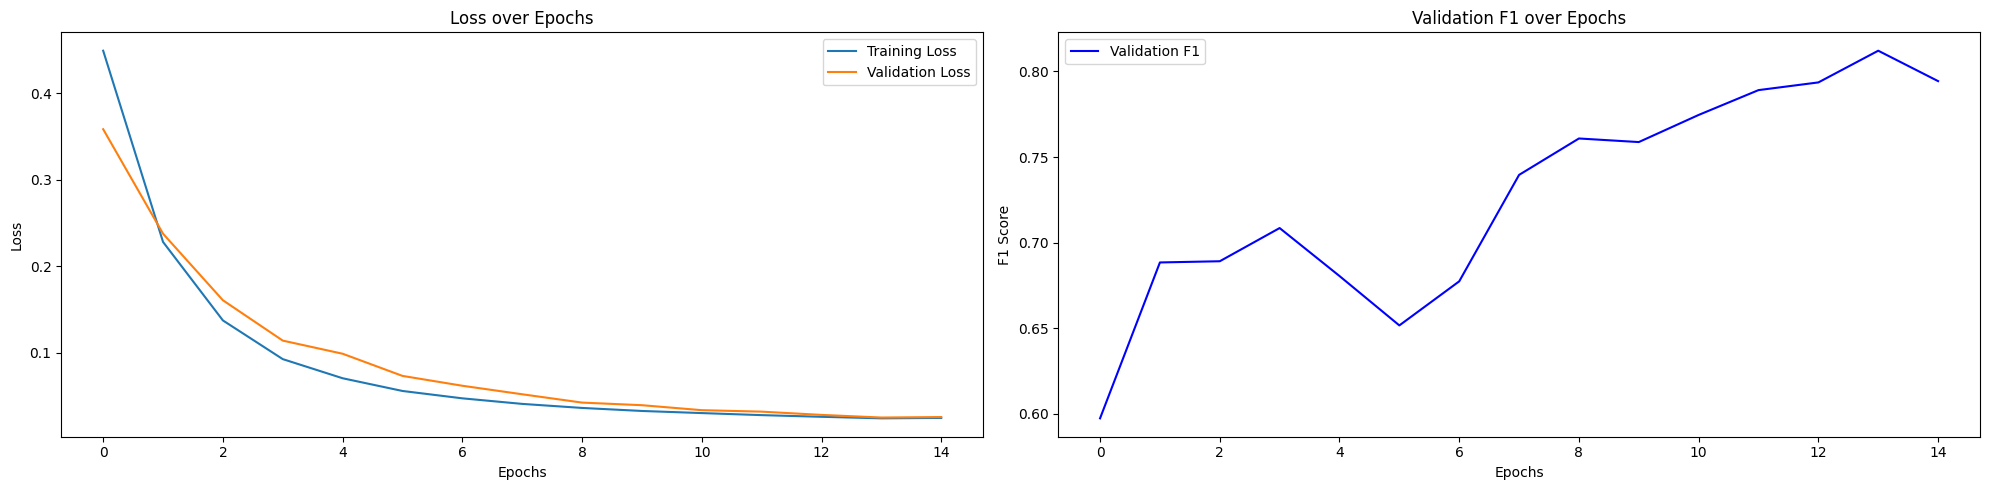

In [28]:
import numpy as np
import torch
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_f1(preds, targets, threshold=0.5):
    """
    Calculates F1 score for multi-label classification.

    Args:
        preds (torch.Tensor): Model predictions (probabilities).
        targets (torch.Tensor): Ground truth labels (binary, multi-label).
        threshold (float): Threshold to convert probabilities to binary predictions.

    Returns:
        float: F1 score.
    """
    preds = (preds > threshold).float().clone()  # Avoid in-place operations
    tp = (preds * targets).sum().to(torch.float32)
    fp = (preds * (1 - targets)).sum().to(torch.float32)
    fn = ((1 - preds) * targets).sum().to(torch.float32)

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    return f1.item()

def find_best_threshold(model, val_loader, device):
    """
    Finds the best threshold for binary classification based on the F1 score.

    Args:
        model (torch.nn.Module): The trained model.
        val_loader (DataLoader): Validation data loader.
        device (torch.device): Device (CPU/GPU).

    Returns:
        tuple: best threshold and its corresponding F1 score.
    """
    thresholds = np.arange(0.1, 1.0, 0.1)
    best_f1 = 0
    best_threshold = 0.5

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    for threshold in thresholds:
        f1 = calculate_f1(all_preds, all_targets, threshold=threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix.

    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted labels.
        class_names (list): List of class names.
    """
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,
                scheduler: torch.optim.lr_scheduler._LRScheduler, train_loader, val_loader, num_epochs: int = 25,
                class_names: list = None) -> torch.nn.Module:
    """
    Trains the model and evaluates it on the validation set.

    Args:
        model (torch.nn.Module): The model to train.
        criterion (torch.nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        train_loader: Training data loader.
        val_loader: Validation data loader.
        num_epochs (int): Number of epochs to train.
        class_names (list): List of class names.

    Returns:
        torch.nn.Module: The trained model.
    """
    best_model_weights = model.state_dict()
    best_f1 = 0.0
    best_threshold = 0.9

    train_losses = []
    val_losses = []
    val_f1s = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                data_loader = train_loader
            else:
                model.eval()
                data_loader = val_loader

            running_loss = 0.0
            running_outputs = []
            running_labels = []

            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_outputs.append(outputs)
                running_labels.append(labels)

            epoch_loss = running_loss / len(data_loader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            epoch_outputs = torch.cat(running_outputs)
            epoch_labels = torch.cat(running_labels)

            print(f'{phase} Loss: {epoch_loss:.5f}')

            if phase == 'val':
                with torch.no_grad():
                    best_threshold, best_f1 = find_best_threshold(model, val_loader, device)
                    val_f1s.append(best_f1)

                print(f'Validation F1 (best threshold={best_threshold}): {best_f1:.5f}')

            if phase == 'train':
                scheduler.step(epoch_loss)

        # Checkpoint for best model based on F1
        if best_f1 > max(val_f1s, default=0):
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, 'best_model.pth')

    print(f'Best validation F1: {max(val_f1s, default=0):.5f}')

    model.load_state_dict(best_model_weights)

    # Plotting Loss
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_f1s, label='Validation F1', color='blue')
    plt.title('Validation F1 over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Example usage of the train_model function
# Assuming criterion, optimizer, scheduler, train_loader, val_loader, and model are defined elsewhere
class_names = ['Actinic', 'Atopic', 'Benign', 'Candidiasis', 'Dermatitis', 'Dermatofibroma',
               'Melanocytic', 'Melanoma', 'Ringworm', 'Squamous', 'Tinea', 'Vascular',
               'Carcinoma', 'Cell', 'Keratosis', 'Lesion', 'Nevus']

trained_model = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=15, class_names=class_names)


Save the Model

In [29]:
# Save the trained model
torch.save(model.state_dict(), 'final_trained_model.pth')


Load the Model

In [30]:
# Assuming you have defined the model architecture again
model.load_state_dict(torch.load('final_trained_model.pth'))  # Load the saved model
model.eval()  # Set the model to evaluation mode


<ipython-input-30-04b557415d30>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_trained_model.pth'))  # Load the saved model


ModifiedDenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [31]:
!pip install scikit-learn

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix for multi-label classification.

    Args:
        y_true (torch.Tensor): True labels.
        y_pred (torch.Tensor): Predicted labels.
        class_names (list): List of class names.
    """
    # Calculate confusion matrix for each label
    cm = multilabel_confusion_matrix(y_true.cpu(), y_pred.cpu())

    # Plot individual confusion matrices
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.ravel()
    for i, (label, matrix) in enumerate(zip(class_names, cm)):
        sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[i])
        axes[i].set_title(label)
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")

    # Remove any unused subplots
    for i in range(len(class_names), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

Model Evaluation

In [32]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score
from tabulate import tabulate

def evaluate_model(model, test_loader, device, class_names, threshold=0.1):
    """
    Evaluate the model on a given data loader and calculate accuracy and F1 scores for each class.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): Data loader for the evaluation dataset.
        device (torch.device): The device to run the model on (CPU or GPU).
        class_names (list): List of class names.
        threshold (float): Threshold to convert probabilities to binary predictions.

    Returns:
        dict: A dictionary containing accuracy, precision, recall, and F1 scores for each class.
        float: The average F1 score across all classes.
    """
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get the model predictions
            outputs = model(images)
            preds = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities

            # Convert probabilities to binary predictions
            preds_binary = (preds > threshold).float()

            all_preds.append(preds_binary.cpu())
            all_targets.append(labels.cpu())

    # Concatenate all predictions and targets
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    # Debugging prints
    print(f"all_targets.shape: {all_targets.shape}")  # Shape should be [num_samples, num_classes]
    print(f"class_names length: {len(class_names)}")  # Should match the number of classes (all_targets.shape[1])

    # Ensure class_names length matches the number of classes
    if all_targets.size(1) != len(class_names):
        raise ValueError(f"Mismatch between the number of classes ({all_targets.size(1)}) and the length of class_names ({len(class_names)}).")

    # Calculate overall accuracy
    correct_predictions = (all_preds == all_targets).float()
    accuracy = correct_predictions.sum() / correct_predictions.numel()

    # Initialize a dictionary to store F1 scores and an average F1 tracker
    f1_scores = {}
    f1_sum = 0
    num_classes = all_targets.size(1)  # Assuming targets shape is [num_samples, num_classes]

    # Create a table list to store class-wise metrics
    table = []

    # Iterate through each class and calculate metrics
    for class_index in range(num_classes):
        precision = precision_score(all_targets[:, class_index], all_preds[:, class_index])
        recall = recall_score(all_targets[:, class_index], all_preds[:, class_index])
        f1 = f1_score(all_targets[:, class_index], all_preds[:, class_index])

        f1_scores[class_names[class_index]] = {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        f1_sum += f1

        # Append metrics for each class (using class names) to the table
        table.append([class_names[class_index], precision, recall, f1])

    # Calculate the average F1 score across all classes
    average_f1 = f1_sum / num_classes

    return accuracy.item(), f1_scores, average_f1, table , all_targets, all_preds # Return accuracy, F1 scores, and table

# Example usage
# Assuming you have a trained model, a data loader, a device, and a list of class names defined
class_names = ['Actinic', 'Atopic', 'Benign', 'Candidiasis', 'Dermatitis', 'Dermatofibroma',
               'Melanocytic', 'Melanoma', 'Ringworm', 'Squamous', 'Tinea', 'Vascular',
               'Carcinoma', 'Cell', 'Keratosis', 'Lesion', 'Nevus']  # Replace with your actual class names
accuracy, f1_scores, average_f1, table, all_targets, all_preds = evaluate_model(model, test_loader, device, class_names, threshold=0.1)

# Print accuracy
print(f"\nModel Accuracy: {accuracy:.4f}\n")

# Display the table with class-wise metrics
headers = ["Class Name", "Precision", "Recall", "F1 Score"]
print(tabulate(table, headers, floatfmt=".4f"))

# Print average F1 score
print(f"\nAverage F1 Score: {average_f1:.4f}")


all_targets.shape: torch.Size([454, 17])
class_names length: 17

Model Accuracy: 0.9671

Class Name        Precision    Recall    F1 Score
--------------  -----------  --------  ----------
Actinic              0.7895    0.8824      0.8333
Atopic               0.9773    0.9556      0.9663
Benign               0.8281    0.9464      0.8833
Candidiasis          1.0000    1.0000      1.0000
Dermatitis           0.9773    0.9556      0.9663
Dermatofibroma       0.9355    0.5370      0.6824
Melanocytic          0.8250    0.8462      0.8354
Melanoma             0.6944    0.5682      0.6250
Ringworm             1.0000    1.0000      1.0000
Squamous             0.8387    0.4815      0.6118
Tinea                1.0000    1.0000      1.0000
Vascular             1.0000    0.9804      0.9901
Carcinoma            0.8333    0.4630      0.5952
Cell                 0.8065    0.4630      0.5882
Keratosis            0.9130    0.7850      0.8442
Lesion               1.0000    0.9804      0.9901
Nevus      

# Top K-Accuracy

In [33]:
def top_k_accuracy_multilabel(model, test_loader, device, k=5):
    """
    Calculate the Top-K accuracy for a multi-label classification model.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): Data loader for the evaluation dataset.
        device (torch.device): The device to run the model on (CPU or GPU).
        k (int): The number of top predictions to consider for Top-K accuracy.

    Returns:
        float: The Top-K accuracy (as a percentage).
    """
    model.eval()  # Set the model to evaluation mode
    correct_top_k = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Get the model predictions
            outputs = model(images)

            # Get the top K predictions for each input (sorted by probability)
            _, top_k_preds = torch.topk(outputs, k, dim=1)  # Get the top K predicted indices

            # For multi-label, we need to check if any of the true labels (that are '1') are in the top K
            for i in range(labels.size(0)):  # Iterate over each sample in the batch
                true_labels = (labels[i] == 1).nonzero(as_tuple=False).squeeze().tolist()  # Get indices of true labels

                # If true_labels is an int (single label), convert it to a list
                if isinstance(true_labels, int):
                    true_labels = [true_labels]

                # If any of the true labels are in the top K predictions
                if any(label in top_k_preds[i].tolist() for label in true_labels):
                    correct_top_k += 1

            total_samples += labels.size(0)

    # Calculate Top-K accuracy
    top_k_acc = correct_top_k / total_samples

    return top_k_acc * 100  # Return as percentage


In [34]:
# Calculate Top-5 accuracy for multi-label classification
top_k_acc_multilabel = top_k_accuracy_multilabel(model, test_loader, device, k=5)
print(f"Top-5 Accuracy (Multi-Label): {top_k_acc_multilabel:.2f}%")

# Calculate Top-3 accuracy for multi-label classification
top_k_acc_multilabel_3 = top_k_accuracy_multilabel(model, test_loader, device, k=3)
print(f"Top-3 Accuracy (Multi-Label): {top_k_acc_multilabel_3:.2f}%")

# Calculate Top-3 accuracy for multi-label classification
top_k_acc_multilabel_4 = top_k_accuracy_multilabel(model, test_loader, device, k=1)
print(f"Top-1 Accuracy (Multi-Label): {top_k_acc_multilabel_4:.2f}%")


Top-5 Accuracy (Multi-Label): 95.37%
Top-3 Accuracy (Multi-Label): 92.29%
Top-1 Accuracy (Multi-Label): 84.80%


# Image Testing

In [41]:
from torchvision import transforms
from PIL import Image

# Define the image preprocessing pipeline
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size according to the model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Use the same normalization used during training
])

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Load the image and convert to RGB
    image = preprocess(image)  # Apply the preprocessing pipeline
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Example usage
image_path = '/content/Extracted_data/test/dr_30_1692_jpg.rf.291429d58e0d185902e099e5a37ed838.jpg'
image_tensor = preprocess_image(image_path)


# Prediction

In [39]:
# Predict the class for the image and return prediction values with class names
def predict_image(model, image_tensor, device, class_names):
    model.eval()
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        preds = torch.sigmoid(outputs)  # Get probabilities (between 0 and 1)

    # Convert tensor to numpy array for easier formatting
    pred_numpy = preds.cpu().numpy()[0]  # Assuming batch size of 1, take first prediction

    # Return the prediction probabilities with corresponding class names
    return pred_numpy

# Example usage
image_tensor = preprocess_image(image_path)  # Assuming preprocess_image is defined elsewhere
pred = predict_image(model, image_tensor, device, class_names)

# Print class names with prediction values rounded to 4 decimal places
for class_name, probability in zip(class_names, pred):
    print(f"{class_name}: {probability:.4f}")


Actinic: 0.0061
Atopic: 0.0074
Benign: 0.0105
Candidiasis: 0.0170
Dermatitis: 0.0049
Dermatofibroma: 0.0057
Melanocytic: 0.0237
Melanoma: 0.1909
Ringworm: 0.0135
Squamous: 0.0416
Tinea: 0.0158
Vascular: 0.0060
Carcinoma: 0.0356
Cell: 0.0326
Keratosis: 0.0089
Lesion: 0.0093
Nevus: 0.0168


# Display the Predictions

In [40]:
def get_class_names_or_highest(pred, class_names, threshold=0.1):
    """
    Get the class names based on predicted probabilities and a specified threshold.
    If no class meets the threshold, return the class name of the highest probability.

    Args:
        pred (torch.Tensor): Predicted probabilities from the model.
        class_names (list): List of class names.
        threshold (float): Threshold to determine the predicted classes.

    Returns:
        list: List of predicted class names or the class name with the highest probability.
    """
    # Convert probabilities to binary predictions based on the threshold
    predicted_classes = (pred > threshold).float()
    class_indices = torch.nonzero(predicted_classes, as_tuple=True)[0]

    if len(class_indices) > 0:
        # If there are classes that exceed the threshold, return their names
        return [class_names[idx] for idx in class_indices]
    else:
        # If no classes exceed the threshold, return the class name with the highest probability
        highest_class_index = torch.argmax(pred).item()
        return [class_names[highest_class_index]]  # Return as a list for consistency

# Example usage
pred = torch.tensor(pred)  # Ensure pred is a torch tensor if not already
predicted_classes = get_class_names_or_highest(pred, class_names, threshold=0.1)

print(f"Predicted classes: {predicted_classes}")


Predicted classes: ['Melanoma']
